## 导入模块

In [1]:
%matplotlib inline
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json, os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from PIL import Image
import csv
import math

## 模型配置

In [2]:
class Config:
    device = 'gpu'
    # train_data为训练图像路径，test_data为测试图像路径，train_lable为训练图像的标签文件
    # save_path为模型参数的保存地址，predict_csv_path为预测csv文件的保存地址
    train_data_path = './train/'
    test_data_path = '../data/dl_detection/test/'
    train_label_path = './train.json'
    save_path = './yolonet.pt'
    predict_csv_path = './test.csv'

    # 输入图像的大小，一定为32的倍数
    input_shape = (416, 416)

    epochs = 15
    # 华为云最高配置可以使用batch_size = 64
    batch_size = 64
    
    # 初始学习率
    init_lr = 1e-2
    # 权重衰减
    weight_decay = 0.0005
    num_classes = 21

    # 正样本损失和负样本损失分配比例
    alpha = 0.85

    # 锚框，正规过程要使用K-means算法生成锚框的大小，这里直接使用官方已经计算好的锚框
    anchor_boxes = {
        13: [[116, 90], [156, 198], [373, 326]],
        26: [[30, 61], [62, 45], [59, 119]],
        52: [[10, 13], [16, 30], [33, 23]],
    }

    # 分别为预测时的iou和nms的阈值
    iou_thresh = 0.4
    nms_thresh = 0.5

## YOLO网络定义
YOLO网络结构大致可以分为三个部分：
* Backbone：即DarkNet-53
* FPN
* YOlO Head

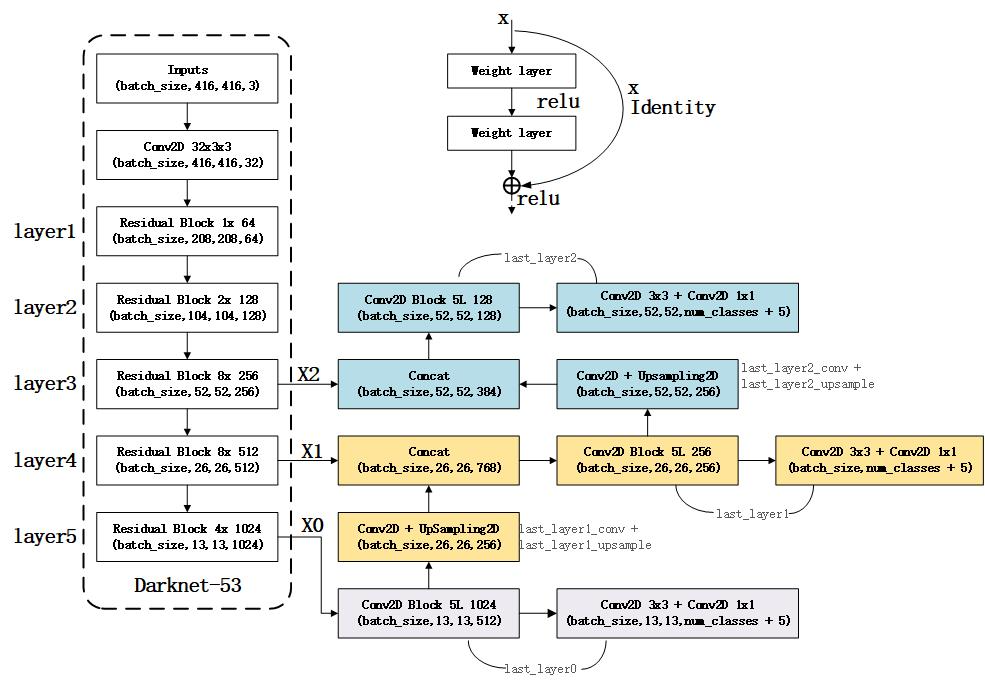

### DarkNet网络定义

In [3]:
class BasicBlock(nn.Module):
    """
        残差块结构
        先用一个1x1卷积下降通道数，然后用一个3x3卷积上升通道数并加上恒等映射
    """
    def __init__(self, inplanes, outplanes):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, outplanes[0], kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1   = nn.BatchNorm2d(outplanes[0])
        # LeakyReLU可以保留一些负轴的信息，而ReLU将负轴信息全部舍弃
        self.relu1 = nn.LeakyReLU(0.1)
 
        self.conv2 = nn.Conv2d(outplanes[0], outplanes[1], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(outplanes[1])
        self.relu2 = nn.LeakyReLU(0.1)
 
    def forward(self, input):
        # 恒等映射
        residual = input
 
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
 
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
 
        output = output + residual
 
        return output


class DarkNet(nn.Module):
    def __init__(self, layers):
        """
            layers是一个列表，表示每个网络层所具有的残差块数量
        """
        super(DarkNet, self).__init__()
        # 输入通道                
        self.first_outplanes = 32
        self.inplanes = self.first_outplanes
        
        # 416,416,3 -> 416,416,32 [Conv2D 32x3x3]
        self.conv1 = nn.Conv2d(3, self.first_outplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(self.first_outplanes)
        # LeakyReLU可以保留一些负轴的信息，而ReLU将负轴信息全部舍弃
        self.relu1 = nn.LeakyReLU(0.1)
 
        # 416,416,32 -> 208,208,64
        self.layer1 = self._make_layer([32, 64], layers[0])
        # 208,208,64 -> 104,104,128
        self.layer2 = self._make_layer([64, 128], layers[1])
        # 104,104,128 -> 52,52,256
        self.layer3 = self._make_layer([128, 256], layers[2])
        # 52,52,256 -> 26,26,512
        self.layer4 = self._make_layer([256, 512], layers[3])
        # 26,26,512 -> 13,13,1024
        self.layer5 = self._make_layer([512, 1024], layers[4])
 
        # 进行权值初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
 
    def _make_layer(self, outplanes, num_blocks):
        """
            该函数进行网络层的构建
            在每一个layer中，首先用步长为2的3×3卷积进行下采样，然后进行残差块的堆叠
        """
        layer = nn.Sequential()


        # 用步长为2的3×3卷积来进行下采样
        layer.add_module("ds_conv", nn.Conv2d(self.inplanes, outplanes[1], kernel_size=3, stride=2, padding=1, bias=False))
        layer.add_module("ds_bn", nn.BatchNorm2d(outplanes[1]))
        layer.add_module("ds_relu", nn.LeakyReLU(0.1))
 
        # 加入残差结构
        self.inplanes = outplanes[1] #更新当前的输入通道数
        for i in range(0, num_blocks):
            layer.add_module(f"residual_{i}", BasicBlock(self.inplanes, outplanes))
        return layer
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        output3 = self.layer3(x)
        output4 = self.layer4(output3)
        output5 = self.layer5(output4)
 
        return output3, output4, output5

### FPN（特征金字塔网络）+ YOLO Head
低层的特征语义信息比较少，但是目标位置准确；高层的特征语义信息比较丰富，但是目标位置比较粗略。FPN将特征进行融合，从而解决多尺度问题。

下面代码将DarkNet、FPN和YOLO Head组合，构成YOLO的网络模型。

In [4]:
class YOLONet(nn.Module):
    def __init__(self):
        super(YOLONet, self).__init__()

        # 生成darknet53的主干模型，获得三个有效特征层，他们的shape分别是：
        # layer3 -> 52,52,256
        # layer4 -> 26,26,512
        # layer5 -> 13,13,1024
        self.backbone = DarkNet([1, 2, 8, 8, 4])

        # yolo层的输出通道数
        self.outplanes = 3 * (Config.num_classes + 5)

        # 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512
        self.last_layer0 = self._make_layer([512, 1024], 1024, self.outplanes)

        self.last_layer1_conv = self.conv2d(512, 256, 1)
        # 上采样，将特征图的大小变为2倍
        self.last_layer1_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        # 512 + 256表示将上采样通道数与darknet的倒数第2个特征层输出通道数相加
        # 26,26,768 -> 26,26,256 -> 26,26,512 -> 26,26,256 -> 26,26,512 -> 26,26,256
        self.last_layer1 = self._make_layer([256, 512], 512 + 256, self.outplanes)

        self.last_layer2_conv = self.conv2d(256, 128, 1)
        self.last_layer2_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        # 52,52,384 -> 52,52,128 -> 52,52,256 -> 52,52,128 -> 52,52,256 -> 52,52,128
        self.last_layer2 = self._make_layer([128, 256], 256 + 128, self.outplanes)


    def conv2d(self, inplanes, outplanes, kernel_size):
        # 保证卷积前后特征图大小不变
        if kernel_size:
            padding = (kernel_size - 1) // 2
        else:
            padding = 0
        
        return nn.Sequential(
            nn.Conv2d(inplanes, outplanes, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(outplanes),
            nn.LeakyReLU(0.1),
        )
    
    def _make_layer(self, planes_list, inplanes, outplanes):
        """
            _make_layer共有7个卷积层，前5个卷积层用于提取特征，后2个卷积层用于获取yolo网络的预测结果
        """
        layer = nn.Sequential(
            self.conv2d(inplanes, planes_list[0], 1),
            self.conv2d(planes_list[0], planes_list[1], 3),
            self.conv2d(planes_list[1], planes_list[0], 1),
            self.conv2d(planes_list[0], planes_list[1], 3),
            self.conv2d(planes_list[1], planes_list[0], 1),
            self.conv2d(planes_list[0], planes_list[1], 3),
            nn.Conv2d(planes_list[1], outplanes, kernel_size=1, stride=1, padding=0, bias=True)
        )
        return layer

    def forward(self, x):
        # 获得三个有效特征层，他们的shape分别是：
        # x2 : layer3 -> 52,52,256
        # x1 : layer4 -> 26,26,512
        # x0 : layer5 -> 13,13,1024
        x2, x1, x0 = self.backbone(x)

        # 处理第一个特征层 -> x0
        # last_layer0[:5] -> 前5层用于提取特征
        # last_layer0[5:] -> 后2层用于获得yolo网络的预测结果
        # 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512 -> 13,13,1024 -> 13,13,512
        output0_branch = self.last_layer0[:5](x0)
        output0 = self.last_layer0[5:](output0_branch)
        # 对out_branch进行卷积
        # 13,13,512 -> 13,13,256 -> 26,26,256
        x1_in = self.last_layer1_conv(output0_branch)
        x1_in = self.last_layer1_upsample(x1_in)
        # 将上采样通道数与darknet的倒数第2个特征层输出通道数相加
        # 26,26,256 + 26,26,512 -> 26,26,768
        x1_in = torch.cat([x1_in, x1], 1)

        # 处理第二个特征层 -> x1
        # 26,26,768 -> 26,26,256 -> 26,26,512 -> 26,26,256 -> 26,26,512 -> 26,26,256
        output1_branch = self.last_layer1[:5](x1_in)
        output1 = self.last_layer1[5:](output1_branch)
        # 26,26,256 -> 26,26,128 -> 52,52,128
        x2_in = self.last_layer2_conv(output1_branch)
        x2_in = self.last_layer2_upsample(x2_in)
        # 52,52,128 + 52,52,256 -> 52,52,384
        x2_in = torch.cat([x2_in, x2], 1)

        # 处理第三个特征层 -> x2
        # 52,52,384 -> 52,52,128 -> 52,52,256 -> 52,52,128 -> 52,52,256 -> 52,52,128
        output2 = self.last_layer2(x2_in)

        return output0, output1, output2

### 网络测试
网络的输入格式为[batch_size, 图像通道数, w, h]

网络的输出格式为[batch_size, data, w, h]

In [5]:
def test_net():
    """ 该函数用来测试YOLO网络的正确性 """
    net = YOLONet()
    data = torch.randn((3,3,416,416))
    y1, y2, y3 = net(data)
    print(y1.shape)
    print(y1)
    print(y2.shape)
    print(y2)
    print(y3.shape)
    print(y3)

# test_net()

## 数据集构造
为了将训练图像数据和标签数据进行相应的处理，并且使用数据迭代器来发挥gpu的并行计算功能，这里需要我们自己定义数据集。

In [6]:
class MyDataSet(Dataset):
    def __init__(self):
        super(MyDataSet, self).__init__()
        # train_labels存储给定的json文件中真实框的信息，格式为
        # {图像id: [[x, y, w, h, category_id], [x, y, w, h, category_id]...], ...}
        self.train_labels = {}

        with open(Config.train_label_path, encoding='UTF-8') as train_label_file:
            self.train_label_json = json.load(train_label_file)
            self.img_info = self.train_label_json['images']
            self.box_info = self.train_label_json['annotations']


    def __len__(self):
        return len(self.img_info)
    

    def __getitem__(self, index):
        index = index % len(self.img_info)
        # boxes的格式为[[cx, cy, w, h, category_id],...]
        img, boxes = self.scale_and_padding(index)
        # 对图像进行标准化
        img_compose = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        img = img_compose(img)

        # labels存放对不同特征图真实框的结果
        labels = {}
        for feature, anchors in Config.anchor_boxes.items():
        # 如果网格中没有框的中心点，对应的label全为0

            labels[feature] = torch.zeros((feature, feature, 3, 5+Config.num_classes), dtype=torch.float32)

            for box in boxes:
                cx, cy, w, h, category_id = box
                # 求中心点的索引和偏移量
                cx_offset, cx_index = math.modf(cx * feature / Config.input_shape[0])
                cy_offset, cy_index = math.modf(cy * feature / Config.input_shape[1])
                
                for i, anchor in enumerate(anchors):
                    # 宽高缩放量
                    p_w, p_h = w / anchor[0], h / anchor[1]
                    # 真实框的面积
                    p_area = w * h
                    # 锚框的面积
                    anchor_area = anchor[0] * anchor[1]

                    # 因为锚框和真实框默认同中心点，所以这里的iou使用的是最小面积除以最大面积
                    iou = min(p_area, anchor_area) / max(p_area, anchor_area)

                    # 注意要是先cy_index后cx_index
                    labels[feature][int(cy_index), int(cx_index), i] = torch.tensor([
                        iou, cx_offset, cy_offset, p_w, p_h,
                        *one_hot(torch.tensor(int(category_id)), Config.num_classes)
                    ])
        return img, labels[13], labels[26], labels[52]
    

    def scale_and_padding(self, index):
        """ 
            该函数将图像补成方形并进行缩放，并对真实框进行同样处理，来使两者对应 
            注意函数的参数index并不是图像的id
        """
        
        img = Image.open(os.path.join(Config.train_data_path, self.img_info[index]['file_name'])).convert('RGB')
        img_id = self.img_info[index]['id']
        img_w, img_h = img.size

        # 选出最大边，从而确定缩放比
        max_side = max(img_w, img_h)
        scale = max_side / max(Config.input_shape)
        img = img.resize((int(img_w/scale), int(img_h/scale)))

        # 这里创建一张新的图像，将原来的图像复制到新图像，从而实现图像补全为方形
        new_img = Image.new('RGB', Config.input_shape, (0, 0, 0))
        if img_w > img_h:
            dy = int((Config.input_shape[1] - img_h/scale) / 2)
            dx = 0
        else:
            dx = int((Config.input_shape[0] - img_w/scale) / 2)
            dy = 0
        new_img.paste(img, (dx, dy))

        # 接着对真实框进行处理
        train_label = torch.tensor(self.get_box_info(img_id), dtype=torch.float32)
        
        train_label[:, :4] = train_label[:, :4] / scale
        train_label[:, 0] = train_label[:, 0] + dx
        train_label[:, 1] = train_label[:, 1] + dy

        # 将原来的真实框左上角坐标转换为真实框中心坐标
        train_label[:, 0] = train_label[:, 0] + train_label[:, 2] / 2
        train_label[:, 1] = train_label[:, 1] + train_label[:, 3] / 2

        return new_img, train_label


    def get_box_info(self, img_id):
        # 之前没有获取过某个图像的真实框就继续获取，否则直接使用之前获取的真实框
        # 这里train_label中的元素格式为[框的左上角x坐标, 框的左上角y坐标, 框的宽度, 框的高度, 类别id]
        if not self.train_labels.get(img_id):
            train_label = []
            for ele in self.box_info:
                if int(ele['image_id']) == img_id:
                    data = ele['bbox'].copy()
                    data.append(ele['category_id'])
                    train_label.append(data)
            self.train_labels[img_id] = train_label
            return train_label
        else:
            return self.train_labels[img_id]
        

### 自定义数据集测试
迭代器的返回格式为 img, labels[13], labels[26], labels[52]

labels格式为 [w, h, 3, 置信度 + cx_offset + cy_offset + p_w + p_h + one_hot ]

In [7]:
def test_dataset():
    """ 测试自定义数据集功能是否正常 """
    ds = MyDataSet()
    print(ds[0][0].shape)
    print(ds[0][1].shape)
    print(ds[0][2].shape)
    print(ds[0][3].shape)
    print(ds[0][1].sum()) # 说明labels[13]不全为0


test_dataset()

torch.Size([3, 416, 416])
torch.Size([13, 13, 3, 26])
torch.Size([26, 26, 3, 26])
torch.Size([52, 52, 3, 26])
tensor(143.7070)


## 损失函数
对于正样本来说，损失分为三个部分：置信度损失、位置损失和分类损失$L_1=L_{cls}+L_{conf}+L_{loc}$

对于负样本来说，损失只有一个部分：置信度损失$L_2$

* 置信度损失使用 BCELoss
* 位置损失使用 MSELoss
* 分类损失使用 CrossEntropy

将两种损失综合起来就是要求的损失$L=\alpha L_1+(1-\alpha)L_2$

In [8]:
def loss(output: torch.Tensor, label: torch.Tensor):
    # 置信度的损失函数，该函数自带sigmoid函数
    conf_loss = nn.BCEWithLogitsLoss()
    # 位置的损失函数
    loc_loss = nn.MSELoss()
    # 分类的损失函数
    cls_loss = nn.CrossEntropyLoss()

    # 通过换轴，将网络输出[batch_size, data, w, h]转换为与标签一致的形状[batch_size, w, h, data]
    output = output.permute(0,2,3,1)
    # 将各个预测框的数据分离，即[batch_size, w, h, data] -> [batch_size, w, h, 3, single_data]
    output = output.reshape(output.shape[0], output.shape[1], output.shape[2], 3, -1)

    # 计算正样本损失
    # 最后一个维度上第一个元素为置信度，如果置信度大于0，即为正样本
    # ...表示省略前面所有的冒号
    mask_pobj = label[..., 0] > 0
    # 获取网络输出的正样本
    output_pobj = output[mask_pobj]
    # 获取训练标签的正样本
    target_pobj = label[mask_pobj]

    loss_pobj_conf = conf_loss(output_pobj[:, 0], target_pobj[:, 0])
    loss_pobj_loc = loc_loss(output_pobj[:, 1:5], target_pobj[:, 1:5])
    loss_pobj_cls = cls_loss(output_pobj[:,5:], torch.argmax(target_pobj[:,5:], dim=1))

    # 正样本的总损失
    loss_pobj = loss_pobj_conf + loss_pobj_loc + loss_pobj_cls 

    mask_noobj = label[..., 0] == 0
    # 获取网络输出的负样本
    output_noobj = output[mask_noobj]
    # 获取训练标签的负样本
    target_noobj = label[mask_noobj]
    # 负样本的总损失只有置信度的损失
    loss_noobj = conf_loss(output_noobj[:,0],  target_noobj[:, 0])

    loss = Config.alpha*loss_pobj + (1-Config.alpha)*loss_noobj
    return loss

## 训练过程

### 训练前的准备
定义数据迭代器、优化器等

In [9]:
net = YOLONet()
data_loader = DataLoader(MyDataSet(), batch_size=Config.batch_size, shuffle=True)
optimizer = torch.optim.Adam(net.parameters(), lr=Config.init_lr, weight_decay=Config.weight_decay)
# 每一个周期学习率减小一半
torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.4, last_epoch=-1)

### 训练函数

In [10]:
def train(net, optimizer, loss, train_ds):

    # 将模型放到GPU上进行训练
    if Config.device == 'gpu' and torch.cuda.is_available():
        net = net.to('cuda:0')
        print('*************在GPU上进行训练*************')

    train_loss_list = []

    # 训练集上的数据迭代器
    for index in range(Config.epochs):
        net.train()
        for i, (img, label_13, label_26, label_52) in enumerate(train_ds):

            if Config.device == 'gpu' and torch.cuda.is_available():
                img = img.to('cuda:0')
                label_13 = label_13.to('cuda:0')
                label_26 = label_26.to('cuda:0')
                label_52 = label_52.to('cuda:0')

            output_13, output_26, output_52 = net(img)
            loss_13 = loss(output_13, label_13)
            loss_26 = loss(output_26, label_26)
            loss_52 = loss(output_52, label_52)

            l = loss_13 + loss_26 + loss_52

            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()

            if i % 10 == 0:
                train_loss_list.append(l.mean())
                print(f"epoch:{index+1} batch:{i+1} loss:{l.mean()}")

    return train_loss_list

In [ ]:
train_loss_list = train(net, optimizer, loss, data_loader)

*************在GPU上进行训练*************
epoch:1 batch:1 loss:42.93815612792969
epoch:1 batch:11 loss:24.582942962646484
epoch:1 batch:21 loss:23.405807495117188
epoch:1 batch:31 loss:28.463871002197266
epoch:1 batch:41 loss:22.260452270507812
epoch:1 batch:51 loss:19.540407180786133
epoch:1 batch:61 loss:24.048261642456055
epoch:1 batch:71 loss:28.395328521728516
epoch:1 batch:81 loss:21.366531372070312
epoch:1 batch:91 loss:24.466747283935547
epoch:1 batch:101 loss:23.07724952697754
epoch:1 batch:111 loss:25.721981048583984
epoch:1 batch:121 loss:25.397727966308594
epoch:1 batch:131 loss:24.432266235351562
epoch:1 batch:141 loss:23.150390625
epoch:1 batch:151 loss:20.569852828979492
epoch:1 batch:161 loss:23.817035675048828
epoch:1 batch:171 loss:20.637371063232422
epoch:1 batch:181 loss:21.675365447998047
epoch:1 batch:191 loss:21.255634307861328
epoch:1 batch:201 loss:20.48726463317871
epoch:1 batch:211 loss:28.3360595703125
epoch:1 batch:221 loss:22.354276657104492
epoch:1 batch:231 lo

In [ ]:
# 保存模型参数
torch.save(net.state_dict(), Config.save_path)

# 画图显示损失变化过程
plt.title('loss')
plt.ylabel('loss')
plt.axis([1, len(train_loss_list)+1, 0, 50])
x = range(1, len(train_loss_list)+1)
plt.plot(x, torch.tensor(train_loss_list, device='cpu'), color='r', linewidth=1.5)
plt.show()